In [26]:
import Pkg

packages = [
    "BoundaryValueDiffEq",
    "ModelingToolkit",
    "MethodOfLines",
    "DifferentialEquations",
    "NonlinearSolve",
    "DomainSets",
    "FFTW",
    "Plots",
    "BifurcationKit",
    "LinearAlgebra",
    "SparseArrays",
    "Setfield",
    "Accessors",
]

Pkg.add(packages)

   Resolving package versions...
  No Changes to `C:\Users\justn\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\justn\.julia\environments\v1.11\Manifest.toml`


In [27]:
using LinearAlgebra
using BoundaryValueDiffEq
using SparseArrays
using ModelingToolkit
using MethodOfLines
using DifferentialEquations
using NonlinearSolve
using DomainSets
using FFTW
using Plots
using BifurcationKit
using Setfield 
using Accessors

In [28]:
# --- 1. Define the Discretized PDE (The Physics) ---
# N points means 2*N variables (N positions + N velocities)
# State vector u = [eta_1, ..., eta_N, v_1, ..., v_N]
function wave_equation_1d!(du, u, p, t)
    N = p.N
    dx = p.dx
    c2 = p.g * p.H
    # Extract views for convenience
    # eta (positions) are the first N elements
    # v (velocities) are the last N elements
    eta = @view u[1:N]
    v   = @view u[N+1:2N]
    
    d_eta = @view du[1:N]
    d_v   = @view du[N+1:2N]
    
    # Loop over grid points
    for i in 1:N
        # 1. Kinematics: d(eta)/dt = v
        d_eta[i] = v[i]
        
        # 2. Dynamics: Wave Equation
        # Finite Difference Laplacian: (eta_right - 2eta + eta_left) / dx^2
        
        # Handle Boundary Conditions (Dirichlet: eta_0 = 0, eta_N+1 = 0)
        eta_left  = (i == 1) ? 0.0 : eta[i-1]
        eta_right = (i == N) ? 0.0 : eta[i+1]
        
        laplacian = (eta_right - 2*eta[i] + eta_left) / (dx^2)
        
        # Non-linear Damping: gamma * v + gamma3 * v^3
        damping = p.gamma * v[i] + p.gamma3 * v[i]^3
        
        # Driving Force (Assume F0 is constant across space for simplicity)
        forcing = p.F0 * sin(p.omega * t)
        
        # Acceleration equation
        d_v[i] = c2 * laplacian + forcing - damping
    end
end

wave_equation_1d! (generic function with 1 method)

In [29]:
# --- 2. Parameters ---
# Physical Constants matching your image context
L = 10.0
N = 10  # Number of grid points (Keep small for shooting method demo)
dx = L / (N + 1)

par_wave = (
    N = N,
    dx = dx,
    g = 9.81,    # Gravity
    H = 1.0,     # Depth
    gamma = 0.1, # Linear damping
    gamma3 = 0.1,# Cubic damping 
    F0 = 5.0,    # Driving amplitude
    omega = 0.5  # Driving frequency (First guess)
)

(N = 10, dx = 0.9090909090909091, g = 9.81, H = 1.0, gamma = 0.1, gamma3 = 0.1, F0 = 5.0, omega = 0.5)

In [30]:
# --- 3. Poincaré Map (Shooting Function) ---
function poincare_map_wave(u, p)
    # Robustly handle omega
    omega = (p isa Real) ? p : p.omega
    T = 2π / abs(omega)
    
    # Integrate the high-dimensional system
    prob = ODEProblem(wave_equation_1d!, u, (0.0, T), p)
    # Using Tsit5 for non-stiff standard wave problems
    sol = solve(prob, Tsit5(), reltol=1e-6, abstol=1e-6, save_everystep=false)
    
    return sol[end] - u
end

poincare_map_wave (generic function with 1 method)

In [31]:
# --- 4. Setup Bifurcation Problem ---
# Initial guess: 2*N zeros
u0 = zeros(2*N)

prob = BifurcationProblem(poincare_map_wave, u0, par_wave, (@optic _.omega);
    record_from_solution = (x, p; k...) -> begin
        # Parameter Reconstruction
        curr_omega = (p isa Real) ? p : p.omega
        p_full = merge(par_wave, (omega = Float64(curr_omega),))
        
        T = 2π / p_full.omega
        prob_rec = ODEProblem(wave_equation_1d!, x, (0.0, T), p_full)
        sol_rec = solve(prob_rec, Tsit5(), reltol=1e-6, abstol=1e-6)
        
        # Metric: We want the Amplitude of the CENTER point of the string
        # Middle index is roughly N/2
        mid_idx = Int(div(p_full.N, 2))
        return maximum(abs.(sol_rec[mid_idx, :]))
    end
)

┌─ Bifurcation Problem with uType Vector{Float64}
├─ Inplace: false
├─ Dimension: 20
├─ Symmetric: false
└─ Parameter: omega

In [32]:
# --- 5. Continuation Options ---
opts = ContinuationPar(
    p_min = 0.1, 
    p_max = 4.0,     
    ds = 0.05,
    max_steps = 100, 
    detect_bifurcation = 0
)

ContinuationPar{Float64, DefaultLS, DefaultEig{typeof(real)}}
  dsmin: Float64 0.0001
  dsmax: Float64 0.1
  ds: Float64 0.05
  a: Float64 0.5
  p_min: Float64 0.1
  p_max: Float64 4.0
  max_steps: Int64 100
  newton_options: NewtonPar{Float64, DefaultLS, DefaultEig{typeof(real)}}
  η: Float64 150.0
  save_to_file: Bool false
  save_sol_every_step: Int64 1
  nev: Int64 3
  save_eig_every_step: Int64 1
  save_eigenvectors: Bool true
  plot_every_step: Int64 10
  tol_stability: Float64 1.0e-10
  detect_fold: Bool true
  detect_bifurcation: Int64 0
  dsmin_bisection: Float64 1.0e-16
  n_inversion: Int64 2
  max_bisection_steps: Int64 25
  tol_bisection_eigenvalue: Float64 1.0e-16
  detect_event: Int64 0
  tol_param_bisection_event: Float64 1.0e-16
  detect_loop: Bool false


In [33]:
# --- 6. Run Continuation ---
println("Starting continuation on 1D Wave Equation (N=$N)...")
branch = continuation(prob, PALC(), opts)

Starting continuation on 1D Wave Equation (N=10)...


 ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 69
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter omega starts at 0.5, ends at 4.0
 ├─ Algo: PALC [Secant]
 └─ Special points:

- #  1, endpoint at omega ≈ +4.00000000,                                                                     step =  68


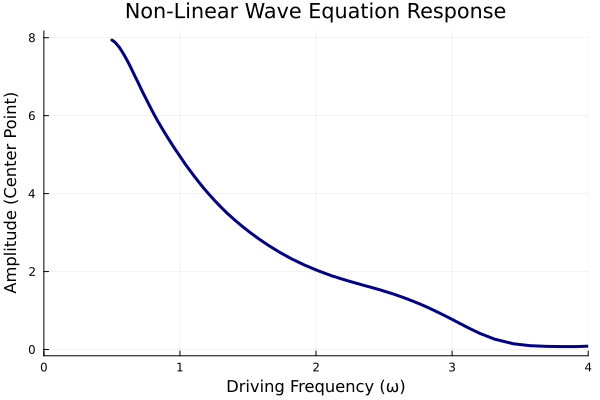

In [34]:
# --- 7. Plotting ---
plot(branch, 
    title = "Non-Linear Wave Equation Response",
    xlabel = "Driving Frequency (ω)",
    ylabel = "Amplitude (Center Point)",
    lw = 3, color = :darkblue, legend = false,
    xlims = (0, 4)
)